In [1]:
import numpy as np
np.random.seed(42)
import sklearn
import os

import keras
import pickle

from keras.layers.advanced_activations import LeakyReLU 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

import pandas as pd
% matplotlib inline



import matplotlib.pyplot as plt
import random
import csv
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from skimage import transform as transf
from sklearn.model_selection import train_test_split
import cv2
from prettytable import PrettyTable
%matplotlib inline

SEED = 22

Using TensorFlow backend.


In [3]:
# Load pickled data
import pickle
from sklearn.model_selection import train_test_split

def load_data():
    training_file = "data/train.p"
    validation_file= "data/valid.p"
    testing_file = "data/test.p"

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
        
    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']
    X_test, y_test = test['features'], test['labels']

    assert(len(X_train) == len(y_train))
    assert(len(X_valid) == len(y_valid))
    assert(len(X_test) == len(y_test))
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()
print("data loaded")


# Summarize the  counts of the data

In [4]:

### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples.
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.bincount(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)



Number of training examples = 39209
Number of validation examples = 12630
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


# List all expanded description of the ouput classes 


In [22]:
# TODO: How many unique classes/labels there are in the dataset.
with open( 'signnames.csv', 'r' ) as sign_name:
    reader = csv.reader(sign_name)
    sign_names = list(reader)

sign_names = sign_names[1::] #Remove csv header
NUM_CLASSES = len(sign_names)
print('Total number of classes: {}'.format(NUM_CLASSES) )

n_classes = len( np.unique(y_train) )
assert (NUM_CLASSES == n_classes), '1 or more class(es) not represented in training set'

sign_name_table = PrettyTable()
sign_name_table.field_names = ['class value', 'Name of Traffic sign']
for i in range(len(sign_names)):
    sign_name_table.add_row([sign_names[i][0], sign_names[i][1]] )
    
print(sign_name_table)


Total number of classes: 43
+-------------+----------------------------------------------------+
| class value |                Name of Traffic sign                |
+-------------+----------------------------------------------------+
|      0      |                Speed limit (20km/h)                |
|      1      |                Speed limit (30km/h)                |
|      2      |                Speed limit (50km/h)                |
|      3      |                Speed limit (60km/h)                |
|      4      |                Speed limit (70km/h)                |
|      5      |                Speed limit (80km/h)                |
|      6      |            End of speed limit (80km/h)             |
|      7      |               Speed limit (100km/h)                |
|      8      |               Speed limit (120km/h)                |
|      9      |                     No passing                     |
|      10     |    No passing for vechiles over 3.5 metric tons    |
|     

# Visualization of the Dataset



In [17]:
import matplotlib.pyplot as plt
import random
import statistics
%matplotlib inline

def compare_distribution_histograms(data, descs):
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4))
    ret_data_bins = []    
    for dataset, desc in zip(data, descs):
        # Create a histogram of the classes
        data_bins = np.bincount(dataset)
        # Convert to percent
        data_bins = data_bins / len(dataset) * 100
        ret_data_bins.append(data_bins)

        print("Dataset {} contains {} samples".format(desc, len(dataset)))
        print("median={:.2f}%  mean={:.2f}%".format(statistics.median(data_bins), statistics.mean(data_bins)))

        ax0.plot(range(len(data_bins)), data_bins, label=desc)
        ax0.set_title('% of samples per class')
        ax0.set_xlabel('class')
        ax0.set_ylabel('% samples')

        ax1.hist(data_bins, bins=20, label=desc)
        ax1.set_title('sample distribution')
        ax1.set_xlabel('% samples')
        ax1.set_ylabel('# classes')
    ax0.legend(loc=1)
    ax1.legend(loc=1)
    plt.show()
    return ret_data_bins



# Compare Distribution Histograms of Training and  Validation  classes

Dataset Training contains 39209 samples
median=1.53%  mean=2.33%
Dataset Validation contains 12630 samples
median=1.43%  mean=2.33%


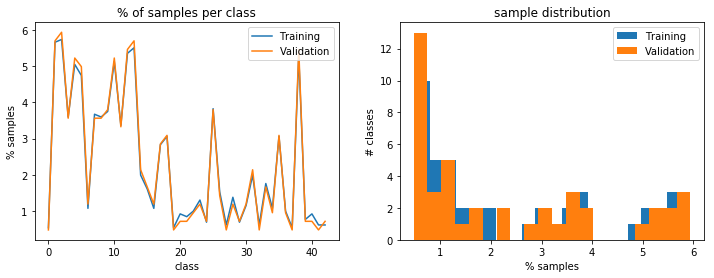

In [15]:
# Let's check if there's similar representation of image classes in the Training and Validation datasets
y_hist = compare_distribution_histograms(data=[y_train, y_valid], descs=["Training", "Validation"])
y_train_hist = y_hist[0]
y_valid_hist = y_hist[1]

# Compare Distribution Histograms of Training and  Test  classes

Dataset Training contains 39209 samples
median=1.53%  mean=2.33%
Dataset Test contains 12630 samples
median=1.43%  mean=2.33%


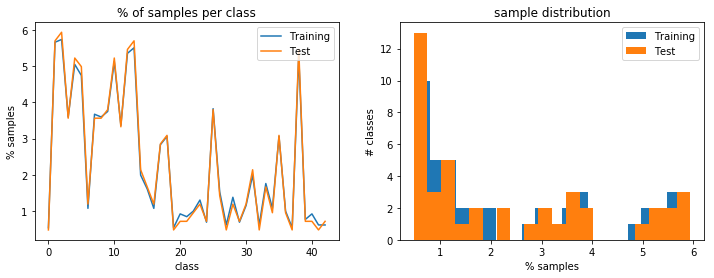

In [16]:
y_hist = compare_distribution_histograms(data=[y_train, y_test], descs=["Training", "Test"])
y_train_hist = y_hist[0]
y_test_hist = y_hist[1]

# Quantitative (Ratios) comparision of the Training and Validation datasets

In [30]:
'''
Print the validation and training datasets per-class representation stats.
The 'ratio' column shows the ratio between the class's representation in the 
training set and its representation in the validation set.
'''
ratio = y_valid_hist/y_train_hist
print("In the following table and graph, a ratio close to 1 indicates that there about the same fraction of validation samples as training samples, in the specific class.")
print("A high ratio means that the class has a larger represnetation in the validation dataset.")
print("Ratio: median={:.2f}  avg={:.2f}\n".format(statistics.median(ratio), statistics.mean(ratio)))

ratio_table = PrettyTable()
ratio_table.field_names = ["Class", "Validation", "Train", "Ratio"]
for i in range(n_classes):
    set_row = ["{:3}".format(i), "{:9.2f}%".format(y_valid_hist[i]),"{:7.2f}%".format(y_train_hist[i]),"{:6.2f}".format(ratio[i])]
    ratio_table.add_row(set_row)
    
print(ratio_table)





In the following table and graph, a ratio close to 1 indicates that there about the same fraction of validation samples as training samples, in the specific class.
A high ratio means that the class has a larger represnetation in the validation dataset.
Ratio: median=0.99  avg=0.97

+-------+------------+----------+--------+
| Class | Validation |  Train   | Ratio  |
+-------+------------+----------+--------+
|    0  |      0.48% |    0.54% |   0.89 |
|    1  |      5.70% |    5.66% |   1.01 |
|    2  |      5.94% |    5.74% |   1.03 |
|    3  |      3.56% |    3.60% |   0.99 |
|    4  |      5.23% |    5.05% |   1.03 |
|    5  |      4.99% |    4.74% |   1.05 |
|    6  |      1.19% |    1.07% |   1.11 |
|    7  |      3.56% |    3.67% |   0.97 |
|    8  |      3.56% |    3.60% |   0.99 |
|    9  |      3.80% |    3.75% |   1.01 |
|   10  |      5.23% |    5.13% |   1.02 |
|   11  |      3.33% |    3.37% |   0.99 |
|   12  |      5.46% |    5.36% |   1.02 |
|   13  |      5.70% |    5.5

# Plot the Ratio Graph (Valid/Train per Class)

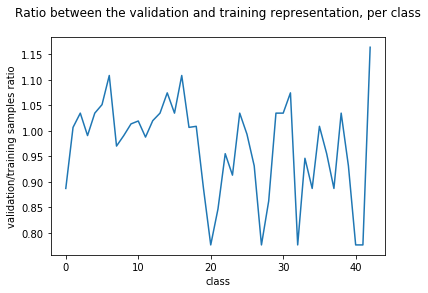

In [32]:
plt.plot(range(n_classes), y_valid_hist/y_train_hist)
plt.title('Ratio between the validation and training representation, per class\n')
plt.xlabel('class')
plt.ylabel('validation/training samples ratio')
plt.show()

In [33]:
"""
Helper plotting functions.
"""

def plot_image(image, nr, nc, i, label=""):
    """
    Plot a single image.
    If 'i' is greater than 0, then plot this image as 
    a subplot of a larger plot.
    """
    
    if i>0: 
        plt.subplot(nr, nc, i)
    else:
        plt.figure(figsize=(nr,nc))
        
    plt.xticks(())
    plt.yticks(())
    plt.xlabel(label)
    plt.tight_layout()
    plt.imshow(image, cmap="gray")

    
import random
def plot_random(dataset1, dataset2=None, instances=1):
    """
    Plot a random image from one or two datasets.
    """
    nc = 1 if dataset2 is None else 2
    nr = instances
    #plt.figure(figsize=(nr,nc))
    for i in range(instances):
        index = random.randint(0, len(dataset1))
        plot_image(dataset1[index].squeeze(), nr, nc, 2*i+1)
        if dataset2 is not None:
            image = dataset2[index].squeeze()
            plot_image(image, nr, nc, 2*i+2)
            print("image mean=", image.mean())


from scipy import misc
def get_image_per_class(X, y):
    """ 
    Plot a representatative of each image class in a 5x10 image grid

    The training dataset is traversed until a sample of each class
    is encountered and cached.

    Another loop then travereses all of the cached images and displays them.
    The two loops are required because we want to display the image samples
    in class order, not in the order they are encountered.
    """
    signs_left = n_classes
    class_images = [None for x in range(signs_left)]

    i = 0
    while signs_left>0:
        if class_images[y[i]] == None:
            image = X[i].squeeze()
            class_images[y[i]] = image
            signs_left -= 1
        i += 1
    return class_images


def summarize_stats(class_images, y_train, y_valid):
    """
    'class_images' is a list of images, one per class.
    This function plots this images list, and print underneath each one its class, 
    the number of training samples, the percent of training samples, 
    and the percent of validation samples
    """
    # Create a histogram of the classes
    y_train_hist = np.bincount(y_train)
    y_valid_hist = np.bincount(y_valid)

    nr = 5; nc = 9
    plt.figure(figsize=(nr,nc))
    for image,i in zip(class_images, range(len(class_images))):
        label = (str(i) + "\n"                                            # class
              + str(y_train_hist[i]) + "\n"                               # no. of training samples
              + "{:.1f}%".format(100 * y_train_hist[i]/sum(y_train_hist))  + "\n"   # representation in training samples
              + "{:.1f}%".format(100 * y_valid_hist[i]/sum(y_valid_hist)))     # representation in validation samples
        plot_image(image, nr, nc, i+1, label)
    





# Display a list of training images, one from each class


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\ipykernel_launcher.py:58: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


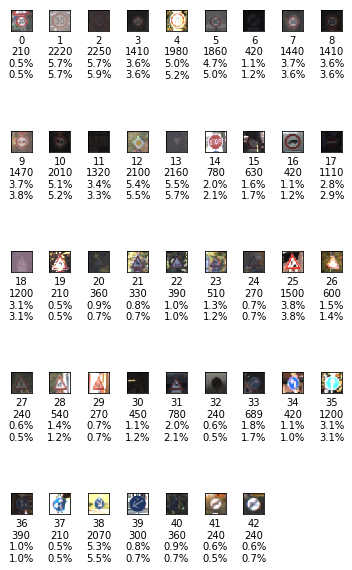

In [34]:

"""
Display a list of training images, one from each class
"""
class_images = get_image_per_class(X_train, y_train)
summarize_stats(class_images, y_train, y_valid)

In [37]:
def get_num_instances(img_class, y):
    """
    Return the number of instances for 'img_class' in dataset 'y'
    """
    y_hist = np.bincount(y)
    n_instances = y_hist[img_class]
    return n_instances

def get_class_images(img_class, X, y):
    """
    Return a list containing all of the images of class 'img_class', 
    from dataset X
    """
    n_instances = get_num_instances(img_class, y)
    class_images = []
    i = 0
    while n_instances>0:
        if y[i] == img_class:
            image = X[i].squeeze()
            class_images.append(image)
            n_instances -= 1
        i += 1
    return class_images

import math
def plot_class_images(img_class, class_images, ncol, desc):
    """
    Plot all of the images in the list 'class_images'
    """
    nimages = len(class_images)
    nrow = math.ceil(nimages/ncol)
    #plt.figure(figsize=(nrow,ncol))
    print("class {} has {} images in the {} dataset".format(img_class,nimages, desc))
    for image,i in zip(class_images, range(nimages)):
        plot_image(image, nrow, ncol, i)
    
def plot_class(img_class, X, y, ncol, desc):
    """
    Plot the images in class 'img_class' from dataset X.
    """
    class_images = get_class_images(img_class, X, y)
    plot_class_images(img_class, class_images, ncol,  desc)

A plot of class 0 validation and training images
class 0 has 60 images in the validation dataset
class 0 has 210 images in the training dataset


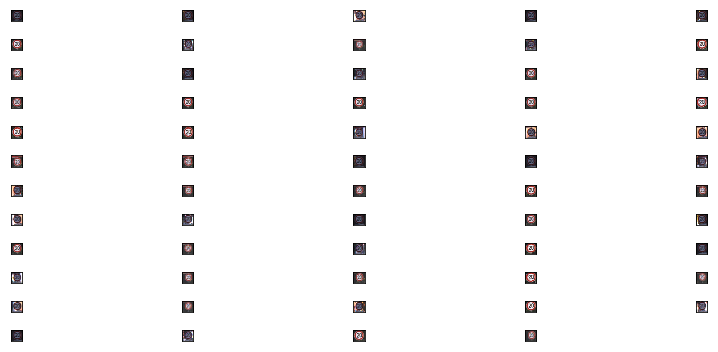

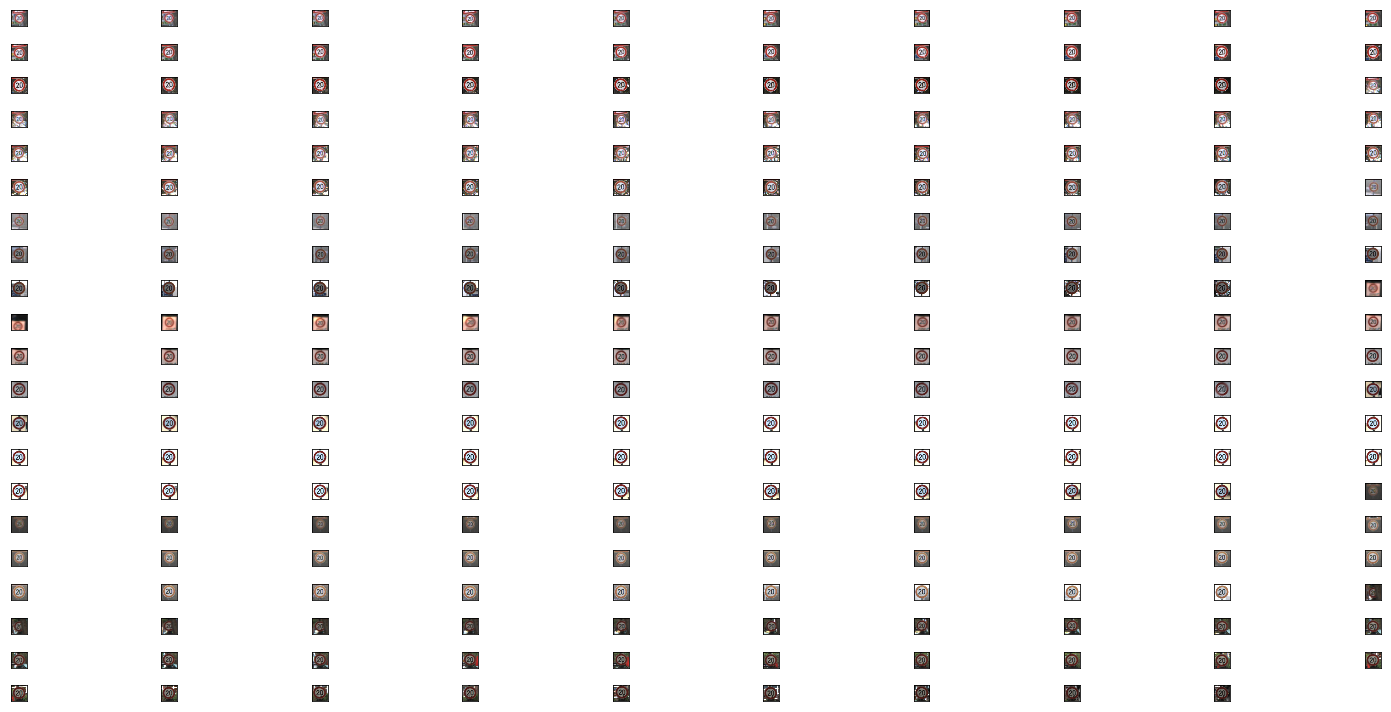

In [38]:
print("A plot of class 0 validation and training images")
plot_class(img_class = 0, X=X_valid, y=y_valid, ncol=5, desc="validation")
plot_class(img_class = 0, X=X_train, y=y_train, ncol=10, desc="training")


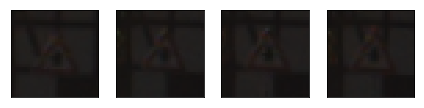

In [40]:
"""
Are these training images really that dark??
"""
class_images = get_class_images(11, X_train, y_train)
for i in range(4):
    plot_image(class_images[i], 1, 4, i+1)

<class 'list'>
4
Histogram of selected images
1
2
3
4
5
6
7
show
1
2
3
4
5
6
7
show
1
2
3
4
5
6
7
show
1
2
3
4
5
6
7
show


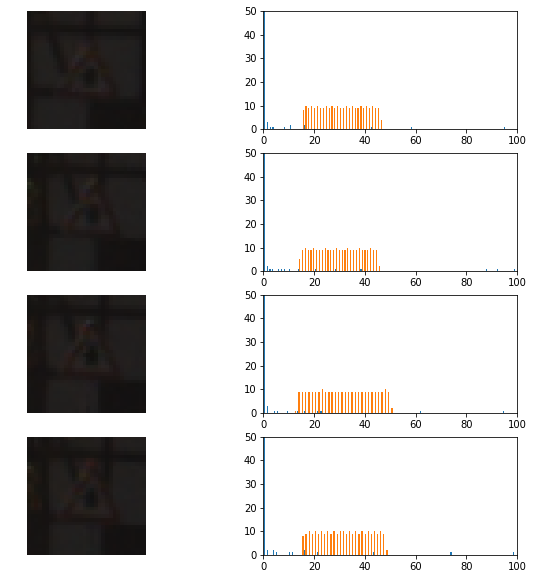

In [50]:
### DATA EXPLORATION: Pixel intensity distribution

def histograms_randImgs(images, channel):
    '''
    Histogram (pixel intensity distribution) for a selection of images with the same label.
    For better visualization, the images are shown in grayscale
    label - the label of the images
    n_imgs - number of images to show (default=5)
    channel - channel used to compute histogram
    ylim - range of y axis values for histogram plot (default=50)
    ''' 
    print(type(images))
    #assert (np.sum(y_train==label)) >= n_imgs, 'reduce your number of images'
    #find all images with the selected label
    num_images = len(images)
    print(num_images)

    _, ax = plt.subplots( num_images, 2, figsize=(10,10))
    print('Histogram of selected images')
    row, col = 0, 0  
    for img in images:
        print("1")

        #display image
        ax[row, col].imshow(img, cmap='gray')
        print("2")
        ax[row,col].axis('off')
        print("3")
        #display histogram
        hist = np.histogram(img, bins=256)
        print("4")
        ax[row, col + 1].hist(hist, bins=256)
        print("5")
        ax[row, col + 1].set_xlim([0, 100])
        print("6")
        ax[row, col + 1].set_ylim([0, 50])
        print("7")
        #initialize col, row value
        col = 0
        row += 1
        print("show")
    plt.show()

histograms_randImgs(class_images[0:4], 3)


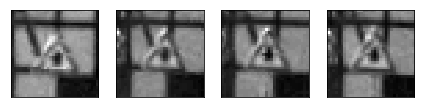

In [41]:
"""
I wonder if converting them to gray-scale will help?
"""
def rgb2gray2d(X):
    gray = np.dot(X, [0.299, 0.587, 0.114])
    gray = gray.reshape(len(X),32,32)
    return gray

dark_images = [class_images[i] for i in range(4)]
gray = rgb2gray2d(dark_images)
for i in range(4):
    plot_image(gray[i], 1, 4, i+1)

<class 'numpy.ndarray'>
4
Histogram of selected images
1
2
3
4
5
6
7
show
1
2
3
4
5
6
7
show
1
2
3
4
5
6
7
show
1
2
3
4
5
6
7
show


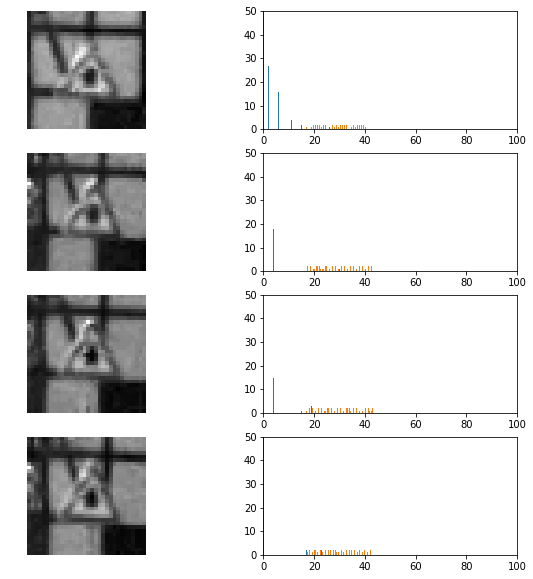

In [51]:
histograms_randImgs(gray, 3)

In [53]:

### Feel free to use as many code cells as needed.
"""
Preprocessing utilities
"""

# Min-Max scaling for grayscale image data
# http://sebastianraschka.com/Articles/2014_about_feature_scaling.html#about-min-max-scaling
def normalize_scale(X):
    a = 0
    b = 1.0
    return a + X * (b-a) / 255

# http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html
def standardize(X):
    X -= np.mean(X) # zero-center
    X /= np.std(X) # normalize
    return (X)

n_channels = 3 # assume default netowrk input is RGB 

def rgb2gray(X):
    #gray = np.dot(X, [:,0.299, 0.587, 0.114])
    gray = np.dot(X, [0.299, 0.587, 0.114])
    gray = gray.reshape(len(X),32,32,1)
    global n_channels
    n_channels = 1
    return gray
    
# preprocessing pipeline
def preprocess_dataset(X):
    X = rgb2gray(X)
    X = normalize_scale(X)
    X = standardize(X)
    return X

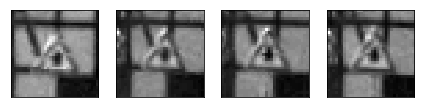

In [54]:
'''
Display some preprocessed images, as a sainty check
'''
preprocessed = preprocess_dataset(np.array(dark_images).astype(np.float32))
for i in range(4):
    plot_image(preprocessed[i].reshape(32,32), 1, 4, i+1)

In [75]:
# Save the data for easy access

pickle_file = 'preprocessed_data.p'
#if not os.path.isfile(pickle_file):
print('Saving data to pickle file...')
try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'y_train': y_train,
                    'X_train': X_train,
                    'X_val': X_val,
                    'y_val': y_val,
                    'X_test': X_test,
                    'y_test': y_test
                },
                pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')
print(X_train.shape[1:])
assert(X_train.shape[1:] == (32,32,1)), "The dimensions of the images are not 32 x 32 x 1."
    

Saving data to pickle file...
Data cached in pickle file.
(32, 32, 1)


In [76]:
import sklearn
import os

import keras
import pickle
pickle_file = 'preprocessed_data.p'

# Reload the data
print(pickle_file)
with open(pickle_file, 'rb') as f:
      pickle_data = pickle.load(f)
      X_train = pickle_data['X_train']
      print(len(X_train))
      y_train = pickle_data['y_train']
      X_val = pickle_data['X_val']
      y_val = pickle_data['y_val']
      X_test = pickle_data['X_test']
      y_test = pickle_data['y_test']
      del pickle_data  # Free up memory
      print("X_train: ", len(X_train))
      print("y_train: ", len(y_train))
      print("X_val: ", len(X_val))
      print("y_val: ", len(y_val))
      print("X_test: ", len(X_test))
      print("y_test: ", len(y_test))

print('Data and modules loaded.')
print(X_train.shape[1:])
assert(X_train.shape[1:] == (32,32,1)), "The dimensions of the images are not 32 x 32 x 1."
    

preprocessed_data.p
39209
X_train:  39209
y_train:  39209
X_val:  12630
y_val:  12630
X_test:  12630
y_test:  12630
Data and modules loaded.
(32, 32, 1)


# SPATIAL TRANSFORMER 

In [8]:
from keras.layers.core import Layer
import tensorflow as tf

class SpatialTransformer(Layer):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Borrowed from [2]_:
    downsample_fator : float
        A value of 1 will keep the orignal size of the image.
        Values larger than 1 will down sample the image. Values below 1 will
        upsample the image.
        example image: height= 100, width = 200
        downsample_factor = 2
        output image will then be 50, 100
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
    """

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        #self.regularizers = self.locnet.regularizers //NOT SUER ABOUT THIS, THERE IS NO MORE SUCH PARAMETR AT self.locnet
        #self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, [-1])
        y_coordinates = tf.reshape(y_coordinates, [-1])
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?

        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, (batch_size, 3, -1))

        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image


# LOCNET

In [9]:
def locnet():

    # initial weights
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((50, 6), dtype='float32')
    weights = [W, b.flatten()]

    input_shape = (32,32,1)

    #locnet
    locnet = Sequential()
    locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
    locnet.add(Conv2D(20, (5, 5)))
    locnet.add(MaxPooling2D(pool_size=(2,2)))
    locnet.add(Conv2D(20, (5, 5)))

    locnet.add(Flatten())
    locnet.add(Dense(50))
    locnet.add(LeakyReLU(alpha=0.5))
    locnet.add(Dense(6, weights=weights))
    return locnet
    #locnet.add(Activation('sigmoid'))

#  CNN model 

In [10]:
def cnn_model(flag_BN=False, flag_STN=False):

    
    model = Sequential()
    if flag_STN == True:
        lnet = locnet()
        print(lnet)
        model.add(SpatialTransformer(localization_net=lnet,
                            input_shape=(32,32,1),output_size=(32,32)))
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=( 32, 32,1)))                    
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same'))

    #model.add(Conv2D(64, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(1024))
    if flag_BN == True:
        model.add(BatchNormalization())  
    model.add(LeakyReLU(alpha=0.5))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))

    model.summary()
    return model

# CNN without Batch Normalization

In [13]:
model = cnn_model()
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/20
 6144/34799 [====>.........................] - ETA: 23s - loss: 3.4695 - acc: 0.0820

KeyboardInterrupt: 

In [ ]:
#save

import matplotlib.pyplot as plt  
plt.figure(1)  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  


with open('CNN_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)


{'val_acc': [0.51405895797033163, 0.76439909378146909, 0.83922902634895302, 0.87029478601317289, 0.88594104135387874, 0.89501133932818633, 0.88072562558310374, 0.91315192522105171, 0.91065759839925098, 0.9170068047484573, 0.91201814261693803, 0.91655329054986001, 0.91995464949921413, 0.92267573579909312, 0.9242630373863947, 0.91814058629833917, 0.92947845848239197, 0.93356009221671665, 0.93151927215982722, 0.92925170111277744], 'val_loss': [1.8259861672546318, 0.91865875472287206, 0.63779906388583363, 0.53541929000088961, 0.48778515337816442, 0.44754030974814141, 0.46086741388519875, 0.3860022514044833, 0.37977416008508125, 0.39402617929744072, 0.41285653779295839, 0.36605362466403418, 0.37229382028114771, 0.38517394522690718, 0.36486099144769091, 0.38345984263755295, 0.3405439810417677, 0.29562408975462795, 0.29894929083566818, 0.32533580637843162], 'acc': [0.26253628017381742, 0.71855513143753191, 0.86901922507575058, 0.91792867693353919, 0.94580304091160128, 0.95844708315383886, 0.9

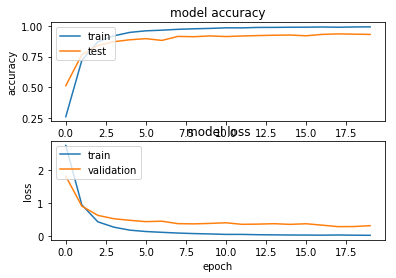

In [14]:
#load

import pickle

history_cnn = pickle.load( open( "CNN_history", "rb" ) )
print(history_cnn)
print(history_cnn.keys())  


import matplotlib.pyplot as plt  
plt.figure(1)  
plt.subplot(211)  
plt.plot(history_cnn['acc'])  
plt.plot(history_cnn['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_cnn['loss'])  
plt.plot(history_cnn['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  




#from keras.models import load_model

#model.save('CNN.h5')  # creates a HDF5 file 'my_model.h5'
#f = open(historyfile, 'wb')
#pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
#f.close()


# returns a compiled model
# identical to the previous one
#model = load_model('CNN.h5')


#model.save('models/CNN.ckpt')
#model.evaluate(X_test,y_test)

# CNN  with Batch Normalization

In [14]:
model = cnn_model(flag_BN=True)
# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/20
 6144/34799 [====>.........................] - ETA: 14s - loss: 3.8123 - acc: 0.1369

KeyboardInterrupt: 

In [10]:
model.save('models/CNN_BN.ckpt')


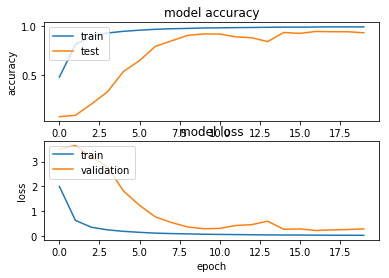

In [11]:
import matplotlib.pyplot as plt  

history_bn = history
plt.figure(1)  
plt.subplot(211)  
plt.plot(history_bn.history['acc'])  
plt.plot(history_bn.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn.history['loss'])  
plt.plot(history_bn.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  


with open('CNN_BN_history', 'wb') as file_pi:
        pickle.dump(history_bn.history, file_pi)


{'val_acc': [0.06961451252233955, 0.08412698418442624, 0.20022675805891993, 0.32585033883853837, 0.53514739283088109, 0.64625850196868651, 0.79387755610234612, 0.84943310852223786, 0.90544217673559035, 0.92086168268099933, 0.91950113475998518, 0.89070294876487888, 0.88117913340224696, 0.84172335952317634, 0.9356009106517108, 0.92630385690265227, 0.9458049944198591, 0.9433106612186043, 0.94285714277604815, 0.93242631066683468], 'loss': [1.9953249581309105, 0.62648496088370076, 0.34863655900279661, 0.24490775232900988, 0.18429271632991148, 0.14464727055602877, 0.11114999467630168, 0.093776666597416111, 0.081090261822010734, 0.068098436226916456, 0.059444362380779756, 0.053858994257270601, 0.047153429915514203, 0.041025107344226826, 0.036135932967007241, 0.035046069489796751, 0.030458797292434923, 0.027050494451494687, 0.026726905947902849, 0.024096010072076658], 'acc': [0.47754245807036622, 0.81206356486683862, 0.89761200042020184, 0.92994051556973767, 0.94755596352389515, 0.959050548150

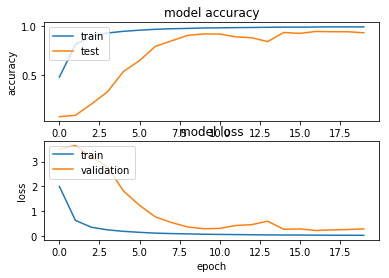

In [12]:
#load

import pickle

history_bn = pickle.load( open( "CNN_BN_history", "rb" ) )
print(history_bn)
print(history_bn.keys())  


import matplotlib.pyplot as plt  
plt.figure(1)  
plt.subplot(211)  
plt.plot(history_bn['acc'])  
plt.plot(history_bn['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn['loss'])  
plt.plot(history_bn['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()  






#from keras.models import load_model

#model.save('CNN.h5')  # creates a HDF5 file 'my_model.h5'
#f = open(historyfile, 'wb')
#pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
#f.close()


# returns a compiled model
# identical to the previous one
#model = load_model('CNN.h5')


#model.save('models/CNN.ckpt')
#model.evaluate(X_test,y_test)

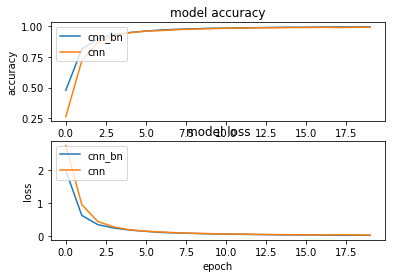

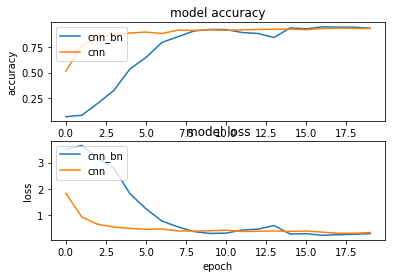

In [17]:



plt.figure(1)  
plt.subplot(211)  
plt.plot(history_bn['acc'])  
plt.plot(history_cnn['acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn['loss'])  
plt.plot(history_cnn['loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
plt.show()  


plt.figure(1)  

plt.subplot(211)  
plt.plot(history_bn['val_acc'])  
plt.plot(history_cnn['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history_bn['val_loss'])  
plt.plot(history_cnn['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['cnn_bn', 'cnn'], loc='upper left')  
plt.show()  

In [18]:
evaluate = model.evaluate(X_test,y_test)


12630/12630 [==============================] - 3s     


In [21]:
print(evaluate)

AttributeError: 'list' object has no attribute 'keys'

# CNN with Batch Normalization and Data Augmentation

In [31]:

#data augmentation

from keras.preprocessing.image import ImageDataGenerator

def get_datagen():


    datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.)

    return datagen

In [31]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#datagen = ImageDataGenerator(
#        rotation_range=40,
#        width_shift_range=0.2,
#        height_shift_range=0.2,
#        shear_range=0.2,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        fill_mode='nearest')

img = load_img('stinkbug.png')  # this is a PIL image

datagen = ImageDataGenerator(zca_whitening=True)

x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='AUG', save_prefix='stinkbug', save_format='png'):
    i += 1
    if i >0:
        break  

C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\keras\preprocessing\image.py:524: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [78]:
# reshape to be [samples][pixels][width][height]
from matplotlib import pyplot

x =  X_train[38969:38969]
#x_t = X_test[0:10]

# convert from int to float
#X_train_aug= x.astype('float32')
#X_test_aug = x_t.astype('float32')
# define data preparation
datagen = ImageDataGenerator(zca_whitening=True)
# fit parameters from data
datagen.fit(X_train_aug)
i = 0

# configure batch size and retrieve one batch of images
for X_batch in datagen.flow(X_train_aug, batch_size=1,

                          save_to_dir='AUG', save_prefix='white', save_format='png'):
       
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i].reshape(32, 32), cmap=pyplot.get_cmap('gray'))
    #show the plot
    pyplot.show()
    break
    


C:\Users\Sarita Navuluru\Anaconda2\envs\tf_a\lib\site-packages\keras\preprocessing\image.py:682: RuntimeWarning: invalid value encountered in true_divide
  sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]


ValueError: array must not contain infs or NaNs

In [79]:
import matplotlib.pyplot as plt

def display_10_images_of_a_label(images, label, labels):
   
    #print(labels.shape)
    plt.figure(figsize=(40, 40))
    # convert from int to float
    
    #print(images.shape)
    itemindex = np.where(labels==label)
    #print(itemindex[0])
    length = (len(itemindex[0][0:10]))
    full_length = len(itemindex[0])
    #print(full_length)
    #print(itemindex[0][0:20])
    indices = itemindex[0][0:10]
    all_indices = itemindex[0]
    imgs = images[itemindex[0:10]]
    imgs2 = images[itemindex[length-11:length-1]]
    all_imgs = images[all_indices]
    i=1
    
    #for i in range(0, 9):
    #   pyplot.subplot(330 + 1 + i)
    #  pyplot.imshow(X_batch[i].reshape(32, 32), cmap=pyplot.get_cmap('gray'))
    #show the plot
    #pyplot.show()
    print(indices)
    for img,indice in zip(imgs,indices) :
        print (indice)
        pyplot.subplot(330+1+i)  # A grid of 8 rows x 8 columns
        pyplot.axis('off')
        pyplot.title("Label {0} ({1})".format(label, indice))
        i += 1
        _ = pyplot.imshow(img)
    pyplot.show()

display_10_images_of_a_label(X_train, 42, y_train)

[]


In [65]:
model = cnn_model(flag_BN=True)
# Compile and train the model



model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train again
epochs = 1
datagen = get_datagen()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=512),
                    steps_per_epoch=X_train.shape[0],
                              
                    epochs=100,verbose=1,
                    validation_data=(X_val, y_val)
                    #callbacks=[LearningRateScheduler(lr_schedule),
                    #           ModelCheckpoint('model.h5', save_best_only=True)]
                    )

NameError: name 'cnn_model' is not defined

# CNN with Batch Normalization and Spatial Transformer, No Data Augmentation

## Spatial Transformer

## Locnet

## STN CNN Model with Batch Normalization

In [13]:


model = cnn_model(flag_BN=True,flag_STN=True)

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=512, nb_epoch=5
                    ,
                    verbose=1, validation_data=(X_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_3 (Spati (None, 32, 32, 1)         14896     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
__________

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 34799 samples, validate on 4410 samples
Epoch 1/5
34799/34799 [==============================] - 20s - loss: 2.0874 - acc: 0.4629 - val_loss: 3.5092 - val_acc: 0.0732
Epoch 2/5
34799/34799 [==============================] - 18s - loss: 0.4675 - acc: 0.8648 - val_loss: 3.8044 - val_acc: 0.1032
Epoch 3/5
34799/34799 [==============================] - 18s - loss: 0.2230 - acc: 0.9390 - val_loss: 3.7720 - val_acc: 0.1707
Epoch 4/5
34799/34799 [==============================] - 18s - loss: 0.1494 - acc: 0.9597 - val_loss: 2.9985 - val_acc: 0.2331
Epoch 5/5
34799/34799 [==============================] - 18s - loss: 0.1121 - acc: 0.9712 - val_loss: 1.9828 - val_acc: 0.5193


In [17]:
import keras.backend as K
XX = model.input
YY = model.layers[0].output
F = K.function([XX], [YY])

In [18]:
batch_size = 512
print(X_train.shape[0]/batch_size)


67.966796875


----------------------------------------
0
12630/12630 [==============================] - 4s     
Epoch: 0 | Valid: [0.23250070902901171, 0.9331065761529399] | Test: [0.31929270194243176, 0.91908155190784213]
0


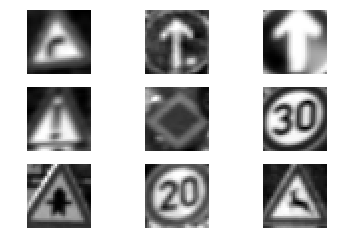

----------------------------------------
0
12608/12630 [============================>.] - ETA: 0sEpoch: 1 | Valid: [0.21325731701861703, 0.94058956935021887] | Test: [0.27896969179642739, 0.93000791770356661]
1


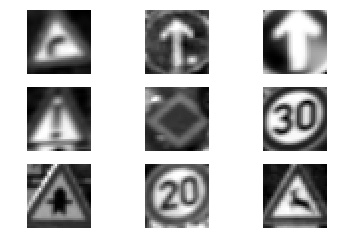

----------------------------------------
0
12608/12630 [============================>.] - ETA: 0sEpoch: 2 | Valid: [0.19271043645484107, 0.95578231292517002] | Test: [0.26167823716184024, 0.93309580366099909]
2


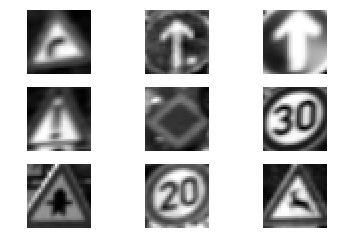

----------------------------------------
0
12512/12630 [============================>.] - ETA: 0sEpoch: 3 | Valid: [0.16874837718245123, 0.96077097524591049] | Test: [0.23016526965470135, 0.94608076017052056]
3


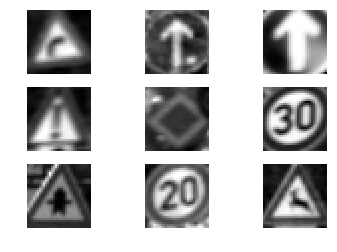

----------------------------------------
0
12512/12630 [============================>.] - ETA: 0sEpoch: 4 | Valid: [0.18657191781466509, 0.95464852626631858] | Test: [0.23426450237525615, 0.944418052303725]
4


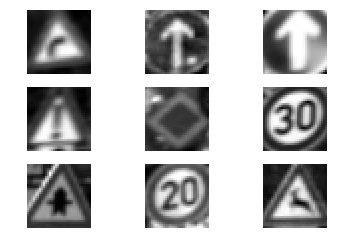

In [27]:
import matplotlib.pyplot as plt
from keras.utils import np_utils, generic_utils

nb_epochs = 5 # you probably want to go longer than this
batch_size = 512
fig = plt.figure()
try:
    for e in range(nb_epochs):
        print('-'*40)
        progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(10):
            print(b)
            f = b * batch_size
            #print(f)
            l = (b+1) * batch_size
            #print(l)
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            progbar.add(X_batch.shape[0], values=[("train loss", loss[0])])
            #progbar.add(args.batch_size, values=[("train loss", loss[0])])

        scorev = model.evaluate(X_val, y_val, verbose=1)
        scoret = model.evaluate(X_test, y_test, verbose=1)
        print('Epoch: {0} | Valid: {1} | Test: {2}'.format(e, scorev, scoret))
        
        if e % 1 == 0:
            print(e)
            Xresult = F([X_batch[:9]])
            #print(Xresult)
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

In [28]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

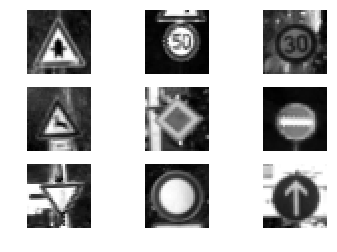

In [29]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

In [46]:
model.save('models/STN_BN_CNN.ckpt')
model.evaluate(X_test,y_test)

12608/12630 [============================>.] - ETA: 0s

[0.18702008974689474, 0.95566112438271378]

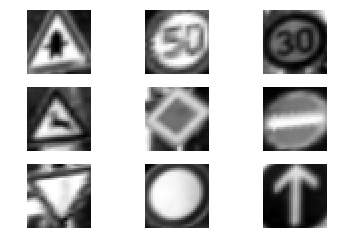

In [30]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')

# CNN with STN, Batch Normalization and Data Augmentation

In [12]:

model = cnn_model(flag_BN=True,flag_STN=True)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

epochs = 5
datagen = get_datagen()
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=512),
                    steps_per_epoch=X_train.shape[0],
                    epochs=5,verbose=1,
                    validation_data=(X_val, y_val)
                    #callbacks=[LearningRateScheduler(lr_schedule),
                    #           ModelCheckpoint('model.h5', save_best_only=True)]
                    )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_2 (Spati (None, 32, 32, 1)         14896     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)        18496     
__________

NameError: name 'get_datagen' is not defined

In [60]:
model.save('models/STN_BN_DA_CNN.ckpt')


In [61]:
model.evaluate(X_test, y_test)

12608/12630 [============================>.] - ETA: 0s

[0.056696130254824374, 0.98875692794932701]

34799


# OTHER STUFF

In [24]:
#Keras tutorial 
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(32,32,3),
                     activation='relu'))
    #model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    #model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    #model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
    return model



datagen = ImageDataGenerator(featurewise_center=False, 
                            featurewise_std_normalization=False, 
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.,)

model = cnn_model()
# let's train the model using SGD + momentum (how original).
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

nb_epoch = 30
model.fit_generator(datagen.flow(X_train, y_train  , batch_size=128),
                            steps_per_epoch=X_train.shape[0],
                            epochs=nb_epoch,
                            validation_data=(X_val, y_val),
                            callbacks=[LearningRateScheduler(lr_schedule),
                                       ModelCheckpoint('model.h5',save_best_only=True)]
                           )

NameError: name 'LearningRateScheduler' is not defined

In [ ]:
import os
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Convolution2D,Conv2D,MaxPooling2D,Flatten
from keras.optimizers import Adam

# number of classes
nb_classes = 43
# input image dimensions
img_rows, img_cols, img_ch = 32, 32, 3
# number of convolutional filters to use
nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (5, 5)
# number of hidden units in the first fully connected layer
nb_fc1=512
nb_fc2=128



model = Sequential()

# Convolution / Max / Pooling / Dropout

model.add(Conv2D(32, (5, 5), border_mode='same', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

#model.add(Conv2D(32, (5, 5), border_mode='same', input_shape=(32, 32, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))
#model.add(Activation('relu'))


#model.add(Conv2D(nb_filter1, kernel_size, strides=pool_strides, padding='same', data_format="channels_last", 
#                    input_shape=(img_rows,img_cols,img_ch),name='conv1'))
#model.add(MaxPooling2D(pool_size=pool_size,strides=pool_strides,name='maxpool1'))
#model.add(Dropout(0.5))

#model.add(Activation('relu',name='relu1'))
model.add(Conv2D(nb_filter2, kernel_size,strides=pool_strides,padding='same',name='conv2'))
model.add(Activation('relu',name='relu2'))
model.add(MaxPooling2D(pool_size=pool_size,strides=None,name='maxpool2'))
model.add(Conv2D(nb_filter3, kernel_size,padding='same',strides=pool_strides, 
                        name='conv3'))
model.add(Activation('relu',name='relu3'))
model.add(MaxPooling2D(pool_size=pool_size,strides=None,name='maxpool3'))
model.add(Flatten(name='flatten'))
model.add(Dropout(0.5,name='dropout1'))
model.add(Dense(nb_fc1, name='hidden1'))
model.add(Activation('relu',name='relu4'))
model.add(Dropout(0.5,name='dropout2'))
model.add(Dense(nb_fc2,  name='hidden2'))
model.add(Activation('relu',name='relu5'))
model.add(Dense(nb_classes, name='output'))
model.add(Activation('softmax',name='softmax'))

model.summary()


nb_epoch = 10
batch_size=128



adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam,
          loss='categorical_crossentropy',
          metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=2, validation_data=(X_val, Y_val))



# STOP: Do not change the tests below. Your implementation should pass these tests.
assert(history.history['val_acc'][-1] > 0.9), "The validation accuracy is: %.3f" % history.history['val_acc'][-1]